[I 2024-10-24 07:42:16,346] A new study created in memory with name: no-name-dd85c85c-0cec-44a8-a6f7-7cbe66004b52
[I 2024-10-24 07:42:17,393] Trial 0 finished with value: 0.8215491808423827 and parameters: {'n_estimators': 195, 'max_depth': 10, 'learning_rate': 0.11895305711198681, 'gamma': 0.37646199945602066, 'reg_alpha': 0.2111983784230318, 'min_child_weight': 3}. Best is trial 0 with value: 0.8215491808423827.
[I 2024-10-24 07:42:18,200] Trial 1 finished with value: 0.8226727763480006 and parameters: {'n_estimators': 248, 'max_depth': 10, 'learning_rate': 0.03713548670846927, 'gamma': 0.41112570756120037, 'reg_alpha': 0.4463315593754267, 'min_child_weight': 3}. Best is trial 1 with value: 0.8226727763480006.
[I 2024-10-24 07:42:18,834] Trial 2 finished with value: 0.8249199673592369 and parameters: {'n_estimators': 249, 'max_depth': 9, 'learning_rate': 0.21701700954773182, 'gamma': 0.49844570928753373, 'reg_alpha': 0.027386978331642386, 'min_child_weight': 5}. Best is trial 2 with 

Accuracy: 84.40%


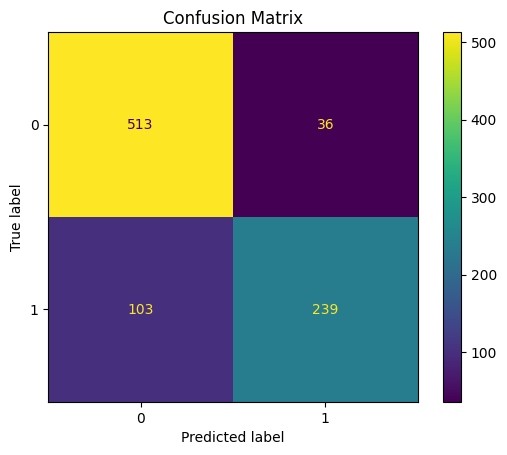

In [11]:
# Required Libraries
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Load data
train_data = pd.read_csv('train.csv', index_col='PassengerId')
test_data = pd.read_csv('test.csv', index_col='PassengerId')
combined_data = [train_data, test_data]


# Step 1: Data Preparation & Feature Engineering
for data in combined_data:
    # Extract Title from Name
    data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

    # Handling Missing Values
    data['Age'] = data.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Embarked'] = data['Embarked'].fillna('S')
    data['CabinIsNull'] = np.where(data['Cabin'].isnull(), 1, 0)

    # Feature Engineering
    data['IsAlone'] = np.where((data['SibSp'] == 0) & (data['Parch'] == 0), 1, 0)
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# Step 2: One-Hot Encoding and Label Encoding for 'Sex'
train_data = pd.get_dummies(train_data, columns=["Title", "Embarked"], prefix=["Title", "Emb"])
test_data = pd.get_dummies(test_data, columns=["Title", "Embarked"], prefix=["Title", "Emb"])

# Label Encoding for 'Sex'
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
test_data['Sex'] = le.transform(test_data['Sex'])

# Drop unnecessary features
drop_columns = ['Name', 'Ticket', 'Cabin', 'Age', 'Fare']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Step 3: Feature Scaling
# Select numerical features for scaling
# Exclude 'Survived' from numerical_features as it's the target variable and not in test_data
numerical_features = train_data.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('Survived')  # Remove 'Survived' from the list


scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
test_data[numerical_features] = scaler.transform(test_data[numerical_features])

# Step 4: Feature Selection using RFE and SelectKBest
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

# RFE - Recursive Feature Elimination
rf_model = RandomForestClassifier()
rfe = RFE(rf_model, n_features_to_select=12)
rfe.fit(X, y)
rfe_features = X.columns[rfe.support_]


# SelectKBest
# Replace chi2 with f_classif to handle negative values
kbest = SelectKBest(f_classif, k=12)
kbest.fit(X, y)
kbest_features = X.columns[kbest.get_support()]

# Combining the selected features
selected_features = list(set(rfe_features) | set(kbest_features))


# Step 5: Model Optimization using Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    gamma = trial.suggest_float('gamma', 0.1, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                          learning_rate=learning_rate, gamma=gamma,
                          reg_alpha=reg_alpha, min_child_weight=min_child_weight)

    return cross_val_score(model, X[selected_features], y, cv=5, scoring='accuracy').mean()

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params

# Step 6: Model Training with Best Parameters
best_model = XGBClassifier(**best_params)
best_model.fit(X[selected_features], y)

# Step 7: Model Evaluation
y_pred = best_model.predict(X[selected_features])

# Accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix using ConfusionMatrixDisplay
cm = confusion_matrix(y, y_pred) # Calculate confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Create display object
disp.plot() # Plot the confusion matrix
plt.title('Confusion Matrix')
plt.show()

# Step 8: Predictions on Test Data
predictions = best_model.predict(test_data[selected_features])
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.to_csv('submission1.csv', index=False)
